## **MIDTERM PROJECT -** 
###For Advanced Process Safety with the guidance of Dr. Tianxing Cai

###Combining HAZOP with dynamic simulation—Applications for safety

### **Part 1: **
####Oxidation of 2-octanol in a semi-batch reactor

Preparation and validation of the simulation model as per the [research idea](https://www.google.com/?gws_rd=ssl) 

`include the paper URL if it is available`


The below is the python routine to solve the system of First-Order Oridinary Differential Equation using `scipy.optimize.odeint` module

In [1]:
#Importing the required library:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import seaborn as sns; sns.set() 

%matplotlib inline

np.random.seed(211) 

#Input Data

maA1 = 10**5 # Pre-exponential factor reaction 1 [m3/kmol/s]
mpA2 = 10**10 # Pre-exponential factor reaction 2[m3/kmol/s]
E1perR = 11300 # Activation temperature reaction 1 [K]
E2perR = 12000 # Activation tempetature reaction 2 [K]
m1 = 6.6 # Hammett's reaction rate coeff. reaction 1
m2 = 2.2 # Hammett's reaction rate coeff. reaction 2
RhoOctan = 820.7 # Density of 2-octanol [kg/m3]
MwOctan = 130.23 # Molar mass of 2-octanol [kg/kmol]
Mw = 63 # Molar mass of HNO3 [kg/kmol]
RhoAcid = 1500 # Density of pure nitric acid [kg/m3]
RhoCPdos = 2 * 10 ** 6 # Heat capacity of dose [J/m3/K]
Tdos = 293.15 # Temperature of feed dose [K]
Hnol = 160 * 10 ** 6 # Specific heat of reaction 1 [J/kmol]
Hnone = 520 * 10 ** 6 # Specific heat of reaction 2 [J/kmole]
RhoCoolant = 1000 # The density of coolant [kg/m3]
CpCoolant = 4183 # Heat capacity of coolant [J/kg/K]
Vj = 1.5 # Volume of the jacket [m3]


#Initial Data

t_0 = 0.0001 # Starting time
Np_0 = 0 # Number of moles of 2-octanone (P) at t = t0
Nx_0 = 0 # Number of moles of carboxylic acids (X) at t = t0
Vr0 = 1.5 # Initial volume in a reactor [m3]
Y = 0.035 # Initial concentr. of nitrosonium ion Y=Nb0/NaF
Percent = 0.6 # Initial mass concentr of nitr. acid sol. [%]
Tr_0 = 260 # Temp. in the reactor at t = t0 (K)
Gamma0 = 5.4 * 10 ** 6 # Initial heat capacity of the system [J/K]
UA0 = 1500 # Initial cool. surface heat trans. coeff.[W/K]
Tcool_0 = 273.15 # Coolant exit temp. at t = t0 (K)
Tcool_IN = 260 # Initial coolant temperature [K]

#Final Data

tf = 72000 # Final time (s)
Vdos1 = 0.6 # Final volume of the dose [m3]
tdos = 36000 # dosing time [s], 10h
UA1 = 2100 # Final cool. surface heat trans. coeff. [W/K]


# Equations


def Mymodel(y,t):
    NnO = Vr0 * Percent * RhoAcid / float(Mw) # Initial number of mole of HNO3 [kmole]
    wt = NnO * Mw / float(Vr0 * RhoAcid) # Mass concentr. of nitric acid sol [%/100%]
    H = -0.6221 - 3.7214 * wt - 1.5714 * wt ** 2 # Hammett's acidity function
    Epsd = Vdos1/float(Vdos1+Vr0) # Volume fraction of dispersed phase
    NaF = (Vdos1 * RhoOctan) / float(MwOctan) # Total amount of 2-octanol (a) fed [kmol]
    tdos = 3600
    if t in range(0,3600):
        Theta = t / float(tdos)
    else:
        Theta=1  # Dimensionless time up to t=tdos
    CaOrg = (Theta * NaF - y[0] - y[1]) / float(Vdos1 * Theta) # Concentr of a in org phase [kmole/m3]
    CpOrg = y[0] / float(Vdos1 * Theta) # Concentr. of (P) in org phase [kmol/m3]
    CbAq = (y[0] + Y * NaF) /float(Vr0) # Concentr. of (B) in aq. phase [kmole/m3]
    Fw = 100 / 60 * 10 ^ (-3)
    NaF = (Vdos1 * RhoOctan) / float(MwOctan) # Total amount of 2-octanol (a) fed [kmol]
    CnAq = (NnO - Y * NaF - y[0] - 2 * y[1]) / float(Vr0) # Concentr. of HNO3 in the aq. phase [kmol/m3]
    k1 = (maA1)*(math.e)**(-E1perR /float( y[2] - (m1*H))) # Specific reaction rate 1
    k2 = (mpA2)*(math.e)**(-E2perR /float(y[2] - (m2*H))) # Specific reaction rate 2 
    r1 = k1*CaOrg*CbAq*(1-Epsd) # Reaction rate of a and b to p[kmol/m3/s]
    r2 = k2*CpOrg*CbAq*(1-Epsd) # Reaction rate of p and b to x[kmol/m3/s]
    dy0 = (r1-r2)*Vr0/(float(1-Epsd))
    dy1 = (r1 * Vr0 / float(1 -Epsd))
    Phi = Vdos1 / tdos # Volumetric flow rate of the feed [m3/s]
    Qdos = Phi * RhoCPdos * (Tdos - y[2]) # Heat input due to reactant addition [W]
    UAcool = UA0 + (UA1 - UA0) * Theta # Cooling surface heat transfer coefficient [W/K]
    Qcool = UAcool * (y[3] - y[2]) # Heat removed by the cooling jacket [W]
    Gamma = Gamma0 + RhoCPdos * Phi * t # Total heat capacity of the system [J/K]
    Qnol = r1 * Vr0 * Hnol / float(1 - Epsd) # Heat of reaction, 1  [W]
    Qnone = r2 * Vr0 * Hnone / float(1 - Epsd) # Heat of reaction, 2 [W]
    Qr = Qnol + Qnone # Sum of the heat of reaction the reactions [W)
    dy2 = (Qr + Qdos + Qcool) / float(Gamma)  #Reactor energy balance (Tr in K)
    dy3 = (Fw * (Tcool_IN - y[3]) - Qcool / float(RhoCoolant * CpCoolant)) / float(Vj)  #Jacket energy balance (T in K)
    return[dy0, dy1, dy2, dy3]

#Input Data

maA1 = 10**5 # Pre-exponential factor reaction 1 [m3/kmol/s]
mpA2 = 10**10 # Pre-exponential factor reaction 2[m3/kmol/s]
E1perR = 11300 # Activation temperature reaction 1 [K]
E2perR = 12000 # Activation tempetature reaction 2 [K]
m1 = 6.6 # Hammett's reaction rate coeff. reaction 1
m2 = 2.2 # Hammett's reaction rate coeff. reaction 2
RhoOctan = 820.7 # Density of 2-octanol [kg/m3]
MwOctan = 130.23 # Molar mass of 2-octanol [kg/kmol]
Mw = 63 # Molar mass of HNO3 [kg/kmol]
RhoAcid = 1500 # Density of pure nitric acid [kg/m3]
RhoCPdos = 2 * 10 ** 6 # Heat capacity of dose [J/m3/K]
Tdos = 293.15 # Temperature of feed dose [K]
Hnol = 160 * 10 ** 6 # Specific heat of reaction 1 [J/kmol]
Hnone = 520 * 10 ** 6 # Specific heat of reaction 2 [J/kmole]
RhoCoolant = 1000 # The density of coolant [kg/m3]
CpCoolant = 4183 # Heat capacity of coolant [J/kg/K]
Vj = 1.5 # Volume of the jacket [m3]


#Initial Data

t_0 = 0.0001 # Starting time
Np_0 = 0 # Number of moles of 2-octanone (P) at t = t0
Nx_0 = 0 # Number of moles of carboxylic acids (X) at t = t0
Vr0 = 1.5 # Initial volume in a reactor [m3]
Y = 0.035 # Initial concentr. of nitrosonium ion Y=Nb0/NaF
Percent = 0.6 # Initial mass concentr of nitr. acid sol. [%]
Tr_0 = 260 # Temp. in the reactor at t = t0 (K)
Gamma0 = 5.4 * 10 ** 6 # Initial heat capacity of the system [J/K]
UA0 = 1500 # Initial cool. surface heat trans. coeff.[W/K]
Tcool_0 = 273.15 # Coolant exit temp. at t = t0 (K)
Tcool_IN = 260 # Initial coolant temperature [K]

#Final Data

tf = 72000 # Final time (s)
Vdos1 = 0.6 # Final volume of the dose [m3]
tdos = 36000 # dosing time [s], 10h
UA1 = 2100 # Final cool. surface heat trans. coeff. [W/K]



#### Defining the python main function 

In [2]:
def main():
    # initial values of y0,y1,y2,y3 at t=0
    yinit = [0.0,0.0,260,273.15]
    # Times at which the solution is to be computed.
    t = np.linspace(0.0001, tf, 10000)
    # Solve the equation.
    y = odeint(Mymodel, yinit , t)
    print 'printing the y array: ', y
    print 'printing the dimension of the array y: ', y.shape
    print 'printing the system y3: ', y[:,3]
    f, axarr = plt.subplots(2, 2)
    axarr[0, 0].plot(t, y[:,0])
    axarr[0, 0].set_title('t vs y0')
    axarr[0, 1].scatter(t, y[:,1])
    axarr[0, 1].set_title('t vs y1')
    axarr[1, 0].plot(t, y[:,2])
    axarr[1, 0].set_title('t vs y2')
    axarr[1, 1].scatter(t, y[:,3])
    axarr[1, 1].set_title('t vs y3')
    
    #astack = np.c_[t, y[:,0],y[:,1],y[:,2],y[:,3]]
    #np.savetxt('approx_1.csv',astack, delimiter=',', header= )

Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
printing the y array:  [[  0.00000000e+000   0.00000000e+000   2.60000000e+002   2.73150000e+002]
 [  2.49716925e-011   3.78115642e+000   3.84050715e+003   4.79055157e+007]
 [  2.44029516e-312   2.77047770e-309   2.46151512e-312   2.77047770e-309]
 ..., 
 [  2.17822911e-315   2.17783291e-315   2.17816318e-315   2.17814121e-315]
 [  2.17785488e-315   2.17794287e-315   2.17803101e-315   2.17805299e-315]
 [  2.17807496e-315   2.17800903e-315   2.17796508e-315   2.17809694e-315]]
printing the dimension of the array y:  (10000L, 4L)
printing the system y3:  [  2.73150000e+002   4.79055157e+007   2.77047770e-309 ...,
   2.17814121e-315   2.17805299e-315   2.17809694e-315]


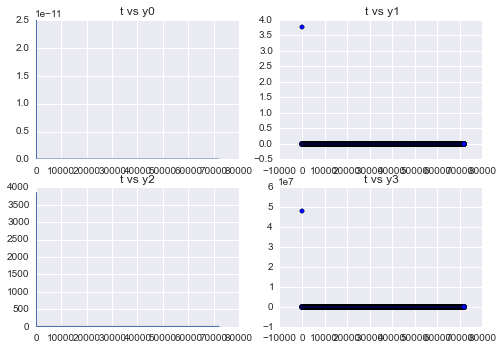

In [5]:
if __name__=="__main__":
    main()

### **Part 2**: Need to apply the result for HAZOP study (to be continued ...)

**References** (for example)

[Stress-induced mutagenesis and complex adaptation](https://www.google.com/), by Yoav Ram and Lilach Hadany (Proceedings B, 2014). 

    